In [388]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
import re
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize
import os
import gzip
import random
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
import pickle
import seaborn as sns
import scikitplot as skplt
import time

In [2]:
#Returns a string of length bytes long

def dataloader(filepath, length):
    f = gzip.GzipFile(fileobj=open(filepath, 'rb'))
    data = f.read(length)
    return data.decode("utf-8")

In [165]:
#Returns dataframe of # of files long. Analyze the first length bytes of each file

def trainloader(direclist, filetype, length):
    fileid = np.arange(len(filetype))
    dat = []
    filelabels = []
    c = -1
    for direc in direclist:
        c+=1
        for file in os.listdir(direc):
            if file.endswith('fna.gz'):
                tempdat = dataloader(os.path.join(direc,file),length)
                dat = dat + [tempdat]
                filelabels.append(0)
            if file.endswith('fna.trunc'):
                tfile = open(os.path.join(direc,file), 'rb')
                tempdat = tfile.read(length).decode("utf-8")
                dat = dat + [tempdat]
                filelabels.append(0)
                
            if file.endswith('gbff.gz'):
                tempdat = dataloader(os.path.join(direc,file),length)
                dat = dat + [tempdat]
                filelabels.append(1)
            if file.endswith('gbff.trunc'):
                tfile = open(os.path.join(direc,file), 'rb')
                tempdat = tfile.read(length).decode("utf-8")
                dat = dat + [tempdat]
                filelabels.append(1)
                
            if file.endswith('gff.gz'):
                tempdat = dataloader(os.path.join(direc,file),length)
                dat = dat + [tempdat]
                filelabels.append(2)
            if file.endswith('gff.trunc'):
                tfile = open(os.path.join(direc,file), 'rb')
                tempdat = tfile.read(length).decode("utf-8")
                dat = dat + [tempdat]
                filelabels.append(2)
                
            if file.endswith('fastq.truncated'):
                tfile = open(os.path.join(direc,file), 'rb')
                tempdat = tfile.read(length).decode("utf-8")
                dat = dat + [tempdat]
                filelabels.append(3)
            if file.endswith('sra.truncated'):
                tfile = open(os.path.join(direc,file), 'rb')
                tempdat = tfile.read(length).decode("ISO-8859-1")
                dat = dat + [tempdat]
                filelabels.append(4)
                
    data = {'Data': dat,
        'Type': filelabels
    }
    df = pd.DataFrame(data, columns = ['Data', 'Type'])
    return(df)

In [4]:
# Returns rows of correctly classified features

def rowextraction(predicted, truth):
    return([np.where(predicted==truth)[0], np.where(predicted!=truth)[0]])

In [5]:
# Returns distribution of probability of class being correct for correctly classified features

def uncertainty(pred, row_ind, num_classes):
    class_arr = [[] for i in range(num_classes)]
    dist_arr = []
    for ind in row_ind:
        class_ind = np.argmax(pred[ind])
        class_arr[class_ind].append(np.max(pred[ind]))
    for arr in class_arr:
        dist_arr.append([np.mean(arr),np.std(arr)])
    return(dist_arr)

In [6]:
# Returns Graphs of Feature Importance by Importance Type

def FeatureImportance(model, features, importance):
    for im in importance:
        feature_important = model.get_score(importance_type = im)
        keys = list(feature_important.keys())
        feature_chars = []
        keylist = []
        for key in keys:
            keylist.append(int(key.replace('f','')))
        for i in keylist:
            feature_chars.append(features[i])
        values = list(feature_important.values())
        fdata = pd.DataFrame(data=values, index=feature_chars, columns=["score"]).sort_values(by = "score", ascending=False)
        fdata.plot(kind='barh', title = im)    
        
    

In [7]:
# Prints Confusion Matrix

def confusionmatrix(truth, pred, names):
    cm = confusion_matrix(truth, pred)
    plt.figure()
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.colorbar().set_label("# Classified")
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Confusion Matrix")
    plt.show()

In [8]:
# Returns Accuracy Per Class

def classaccuracy(truth, pred, ind, num_classes):
    classes = np.arange(num_classes)
    predcl = np.asarray([np.argmax(pred[i]) for i in ind])
    acc = []
    for cl in classes:
        truth_len = len(np.where(truth == cl)[0])
        pred_len = len(np.where(predcl == cl)[0])
        acc.append(pred_len/truth_len)
    return(acc)

In [359]:
#Splits our data into train/test

def Data_Splitter(Dataset, ttsplit):
    X = Dataset.iloc[:,0]
    y = Dataset.iloc[:,1]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ttsplit , stratify = y, random_state = 42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=ttsplit , stratify = y_train, random_state = 42)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [40]:
# Tf-idf Transformation on Training and Testing data based on max_features # of vocabulary words
# generated from each file class.

def Char_vectorizer2(X_train, y_train, X_test, y_test, filetype, ngram_range, max_features, load):
    
    fitset = trainselector2(np.array(X_train), np.array(y_train), len(filetype))
    
    if load == False:
        start = time.time()
        print("Generating Character Vectorizer...")
        char_vocab = {}
        for fileset in fitset:
            char_vectorizer = TfidfVectorizer(analyzer = 'char',
                ngram_range = ngram_range, max_features = max_features)
            char_vectorizer.fit(fileset)
            char_vocab.update(char_vectorizer.vocabulary_)
            
        count = -1
        for key in char_vocab.keys():
            count+=1
            char_vocab[key] = count
            
    
        char_vectorizer2 = TfidfVectorizer(analyzer = 'char',
                ngram_range = ngram_range, max_features = max_features,
                                vocabulary = char_vocab)
        char_vectorizer2.fit(X_train)
        print(char_vectorizer2.get_feature_names())
        
        train_chars = char_vectorizer2.transform(X_train)
        test_chars = char_vectorizer2.transform(X_test)
        pickle.dump(char_vectorizer2, open("tfidfcv2.pkl", "wb"))
        print("Character Vectorizer Saved")
        end = time.time()
        print("Vectorizer Train Time: %d" % (end-start))
        
    if load == True:
        start = time.time()
        print("Loading Character Vectorizer...")
        char_vectorizer = pickle.load(open("tfidfcv2.pkl", 'rb'))
        print("Character Vectorizer Loaded")
    
        print(char_vectorizer.get_feature_names())
        train_chars = char_vectorizer.transform(X_train)
        test_chars = char_vectorizer.transform(X_test)
        end = time.time()
        print("Vectorizer Load Time: %d" % (end-start))

    dtrain = xgb.DMatrix(train_chars, label = y_train)
    dtest = xgb.DMatrix(test_chars, label = y_test)
    
    
    
    return dtrain, dtest

In [366]:
# Prints amount of files per class and percentage representation of each class per set

def classcounts(y_set, nclass):
    for y in y_set:
        y = np.asarray(y)
        counts = [[] for i in range(nclass)]
        percs = [[] for i in range(nclass)]
        labels = np.arange(nclass)
        for c in range(nclass):
            local = len(np.where(y == c)[0])
            counts[c] = local
            percs[c] = local/len(y)
        print(counts)
        print(percs)
        


In [153]:
# Vectorizes test set and converts to DMatrix

def test_char_vectorizer(X_test):
    start = time.time()
    print("Loading Character Vectorizer...")
    char_vectorizer = pickle.load(open("tfidfcv2.pkl", 'rb'))
    print("Character Vectorizer Loaded")
    print(char_vectorizer.get_feature_names())
    
    test_chars = char_vectorizer.transform(X_test)
    
    dtest = xgb.DMatrix(test_chars)
    end = time.time()
    print("Vectorizer Load Time: %d" % (end-start))
    
    return dtest

In [12]:
# Splits our training data into parts by filetype

def trainselector2(train_data, train_label, n_class):
    labelmat = [[] for i in range(n_class)]
    
    for c in range(n_class):
        t_labelloc = np.where(train_label == c)[0]
        labelmat[c].extend(train_data[t_labelloc])
    
    return(labelmat)
        

In [297]:
# Trains XGB Classifier

def TrainFileClassifier(param, num_round, train_dat, val_dat, load):
    if load == False:
        start = time.time()
        print("Training Model...")
        model = xgb.train(param, train_dat, num_round, evals = [(train_dat, 'train'), (val_dat, 'eval')], verbose_eval = True)
        pickle.dump(model, open("xgb_class.pkl", "wb"))
        print("Model Saved")
        end = time.time()
        print('Training time: %d' % (end-start))
    if load == True:
        print("Loading Model...")
        model = pickle.load(open("xgb_class.pkl", "rb"))
        print("Model Loaded")
        
    return model
    

In [410]:
# Tests XGB Classifier

def TestFileClassifier(model, data_test, filetype, y_test, output, threshold, threshold_plots):
  
    global_precision = []
    global_recall = []
    global_F1 = []
    global_class = [[] for c in range(len(filetype))]

    
    for thperc in threshold:
        y_test = np.asarray(y_test)
        
        y_test_threshold = []
        preds_threshold = []
        start = time.time()
        preds = model.predict(data_test)
        end = time.time()
        #print('Testing time: %d' % (end-start))
        best_preds = []
        belowthresh = 0
        below_ind = []
        count = -1
        for p in range(len(y_test)):
            if np.max(preds[p]) < thperc:
                belowthresh += 1
     
                below_ind.append(p)
                
            else:
                y_test_threshold.append(y_test[p])
                preds_threshold.append(preds[p])
                best_preds.append(np.argmax([preds[p]]))
        
        best_preds = np.array(best_preds)
        y_test_threshold = np.array(y_test_threshold)
        new_preds = np.delete(preds, below_ind,0)
        
        local_precision = precision_score(y_test_threshold, best_preds, average='macro')
        local_recall = recall_score(y_test_threshold, best_preds, average = 'macro')
        local_F1 = 2*(local_precision*local_recall)/(local_precision + local_recall)
        global_precision.append(local_precision)
        global_recall.append(local_recall)
        global_F1.append(local_F1)
        
        Y_bin = label_binarize(y_test_threshold, classes = [*range(len(filetype))])
        #Y_score = model.predict_proba(data_test)
        curr_thresh = thperc
        
        prec = dict()
        rec = dict()
        for f in range(len(filetype)):
            prec[f],rec[f],_ = precision_recall_curve(Y_bin[:,f], new_preds[:,f])
            plt.plot(rec[f], prec[f], lw = 2, label = 'class '+filetype[f])
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend(loc="best")
        plt.title("Precision vs. Recall Curve for Threshold: {}".format(curr_thresh))
        plt.figure(figsize = (20,10))
        plt.show()
        
        
        fpr = dict()
        tpr = dict()
        for e in range(len(filetype)):
            fpr[e], tpr[e], _ = roc_curve(Y_bin[:, e],
                                          new_preds[:, e])
            plt.plot(fpr[e], tpr[e], lw=2, label='class '+filetype[e])

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="best")
        plt.title("ROC Curve for Threshold: {}".format(curr_thresh))
        plt.show()

        
        if output == True:
            char_vectorizer = pickle.load(open("tfidfcv2.pkl", 'rb'))
            FeatureImportance(model, char_vectorizer.get_feature_names(), ['weight','cover','gain'])
            
            print("Precision: {}".format(local_precision))
            print("Recall: {}".format(local_recall))
            print("F1: {}".format(local_F1))
            
            y_test_arr = np.asarray(y_test_threshold).reshape(1,-1).squeeze()
            correct_rows = rowextraction(best_preds,y_test_arr)[0]
            incorrect_rows = rowextraction(best_preds,y_test_arr)[1]
            class_acc = classaccuracy(y_test_arr, preds_threshold, correct_rows, len(filetype))
            pred_uncertainty = uncertainty(preds, correct_rows, len(filetype))
            for i in range(len(filetype)):
                global_class[i].append(round(class_acc[i],2))
                
            for i in range(param['num_class']):
                print("Class {}".format(filetype[i]) + " mean and sd: {}".format(pred_uncertainty[i])
                     + ", Accuracy: {}".format(round(class_acc[i],2)))
            confusionmatrix(y_test_arr, best_preds, filetype)
            skplt.metrics.plot_roc(y_test_arr, new_preds)
            plt.show()

    if threshold_plots == True:
        fig, ax = plt.subplots()

        ax.plot(threshold, global_precision)
        ax.set(xlabel = '% Confident Threshold', ylabel = 'Precision', title = 'Threshold vs Precision')
        ax.grid()
        plt.figure(figsize = (20,10))

        plt.show()
        
        fig, ax = plt.subplots()

        ax.plot(threshold, global_recall)
        ax.set(xlabel = '% Confident Threshold', ylabel = 'Recall', title = 'Threshold vs Recall')
        ax.grid()
        plt.figure(figsize = (20,10))

        plt.show()
        
        fig, ax = plt.subplots()

        ax.plot(threshold, global_F1)
        ax.set(xlabel = '% Confident Threshold', ylabel = 'F1', title = 'Threshold vs F1')
        ax.grid()
        plt.figure(figsize = (20,10))

        plt.show()
        
        fig, ax = plt.subplots()

        ax.plot(global_recall, global_precision)
        ax.set(xlabel = 'recall', ylabel = 'precision', title = 'Global Precision Recall')
        ax.grid()
        plt.figure(figsize = (20,10))

        plt.show()
        
        
    if threshold_plots == True and output == True:
        for cl in range(len(filetype)):
            figc, axc = plt.subplots()
            axc.plot(threshold, global_class[cl])
            axc.set(xlabel = '% Confident Threshold', ylabel = filetype[cl] + ' accuracy', title = 'Threshold vs ' + filetype[cl])
            axc.grid()
            plt.figure(figsize = (20,10))

            plt.show()

    print(len(best_preds))
    print(len(y_test))
    print(len(best_preds)/len(y_test))
    return best_preds

In [285]:
dirs = ['/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.fna',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.gbff',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/genomic.gff',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/FASTQ_truncated',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/TruncFASTQ10000',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/SRA_truncated',
        '/Users/bf/Desktop/BNL2020/BioClassifierFiles/TruncSra10000'
       ]
filetype = ['fna', 'gbff', 'gff', 'fastq', 'sra']
data_iterable = trainloader(dirs, filetype, 3000)

In [309]:
param = {
    'max_depth': 10,  # the maximum depth of each tree
    'eta': 0.1,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': len(filetype),  # the number of classes that exist in this datset
    'booster' : 'dart', # Dropout added
    'rate_drop' : 0.4, #Dropout Rate
    'skip_drop' : 0.4, # Probability of skipping Dropout
    } 
num_round = 40 # Number of rounds we train our XGB Classifier
ngram_range = (4,8) # Character length we search by for Tfidf
max_features = 12 # Vocab Words Per File Class
Dataset = data_iterable
ttsplit = 0.2  # Train/Test Split Percentage

In [360]:
X_train, X_val, X_test, y_train, y_val, y_test = Data_Splitter(Dataset, ttsplit)

In [367]:
classcounts([y_train,y_val,y_test],5)

[7212, 7215, 7226, 10798, 6439]
[0.18544613011056826, 0.18552327076369246, 0.18580611982514786, 0.2776549241450244, 0.16556955515556698]
[1803, 1803, 1807, 2700, 1610]
[0.18543659364393705, 0.18543659364393705, 0.18584798930371285, 0.27769207034865784, 0.16558675305975523]
[2254, 2255, 2258, 3375, 2012]
[0.1854533486917887, 0.1855356261313148, 0.18578245844989305, 0.2776863584005266, 0.16554220832647687]


In [368]:
dat2_train, dat2_val = Char_vectorizer2(X_train, y_train, X_val, y_val, filetype, ngram_range, max_features, load = False)

Generating Character Vectorizer...
['aaaa', 'tttt', 'tatt', 'taaa', 'gaaa', 'aaat', 'aatt', 'attt', 'ttta', 'agaa', 'aaga', 'gaag', 'tion', 'ion ', ' gen', 'geno', 'enom', 'nome', ' :: ', 'atio', 'tion ', 'genom', 'enome', 'ation', '=gen', 'prot', 'rote', 'otei', 'tein', 'prote', 'rotei', 'otein', 'protei', 'rotein', 'protein', 'gene', 'gggg', 'ffff', 'hhhh', 'fffff', 'ggggg', 'ffffff', 'gggggg', 'fffffff', 'ggggggg', 'gggggggg', 'ffffffff', 'iiii', '\x01\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00$', '\x00\x00$\x01', '\x00$\x01\x00', '$\x01\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00$', '\x00\x00$\x01\x00', '\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00\x00']
Character Vectorizer Saved
Vectorizer Train Time: 1127


In [369]:
model2 = TrainFileClassifier(param, num_round, dat2_train, dat2_val, load = False)

Training Model...
[10:32:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.00735	eval-merror:0.01224
[1]	train-merror:0.00656	eval-merror:0.01111
[2]	train-merror:0.00589	eval-merror:0.01018
[3]	train-merror:0.00581	eval-merror:0.01029
[4]	train-merror:0.00581	eval-merror:0.00987
[5]	train-merror:0.00568	eval-merror:0.00946
[6]	train-merror:0.00563	eval-merror:0.00885
[7]	train-merror:0.00561	eval-merror:0.00874
[8]	train-merror:0.00550	eval-merror:0.00864
[9]	train-merror:0.00545	eval-merror:0.00823
[10]	train-merror:0.00522	eval-merror:0.00833
[11]	train-merror:0.00517	eval-merror:0.00823
[12]	train-merror:0.00517	eval-merror:0.00823
[13]	train-merror:0.00517	eval-merror:

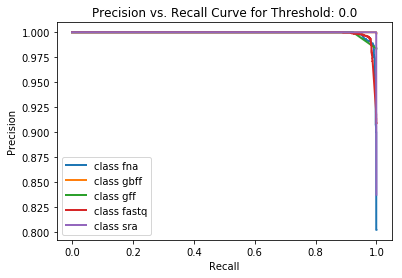

<Figure size 1440x720 with 0 Axes>

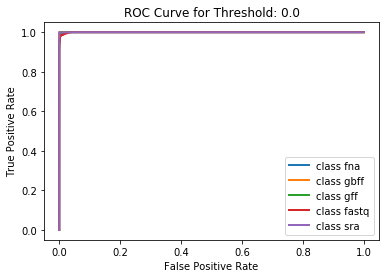

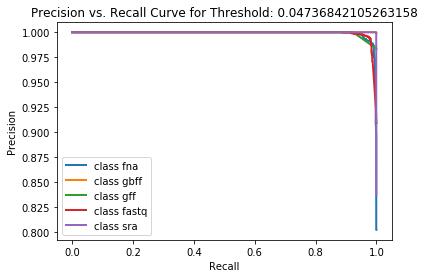

<Figure size 1440x720 with 0 Axes>

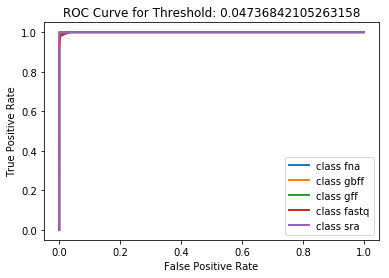

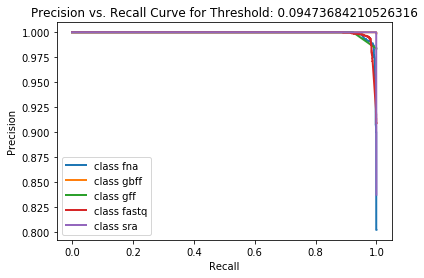

<Figure size 1440x720 with 0 Axes>

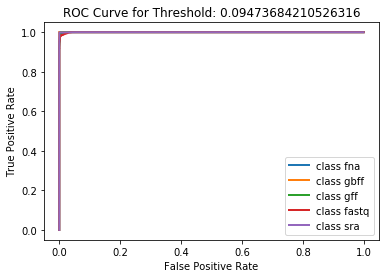

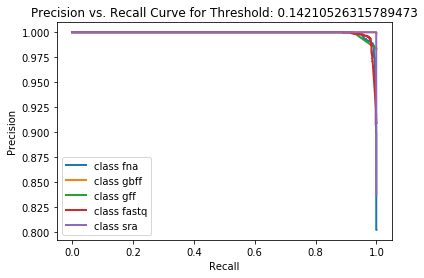

<Figure size 1440x720 with 0 Axes>

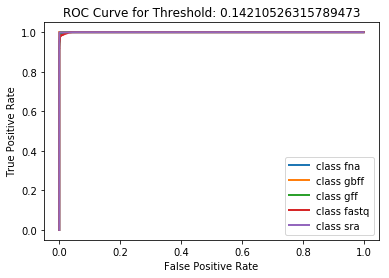

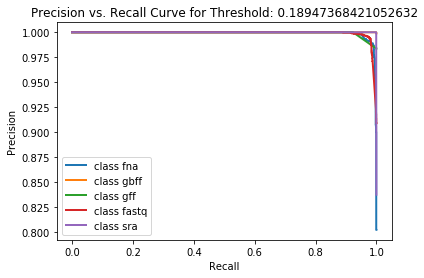

<Figure size 1440x720 with 0 Axes>

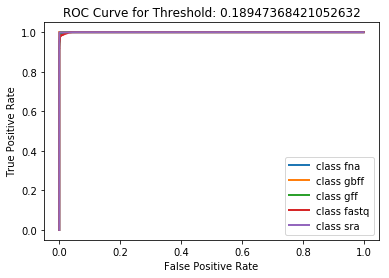

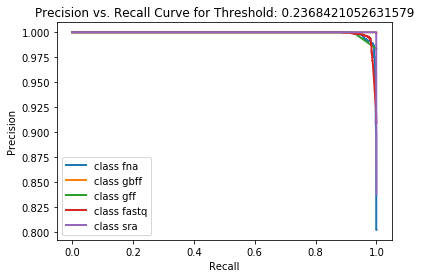

<Figure size 1440x720 with 0 Axes>

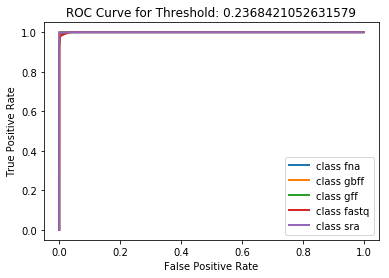

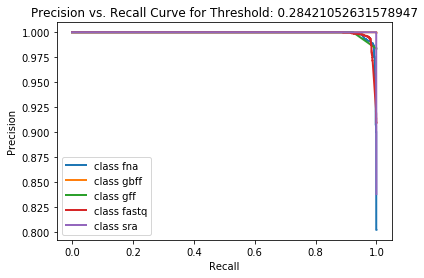

<Figure size 1440x720 with 0 Axes>

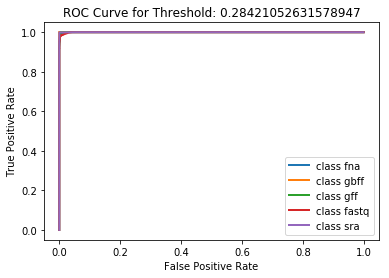

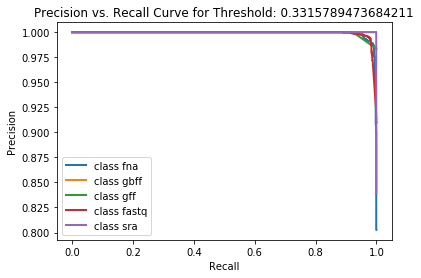

<Figure size 1440x720 with 0 Axes>

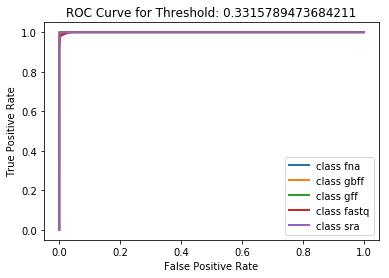

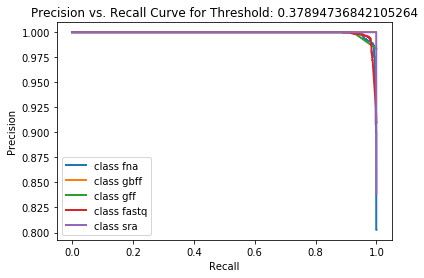

<Figure size 1440x720 with 0 Axes>

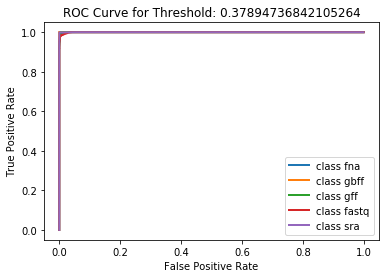

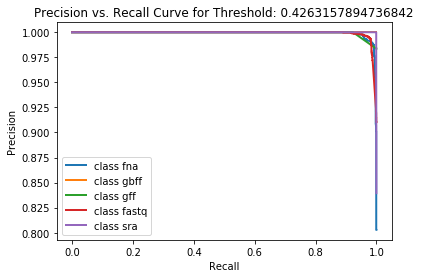

<Figure size 1440x720 with 0 Axes>

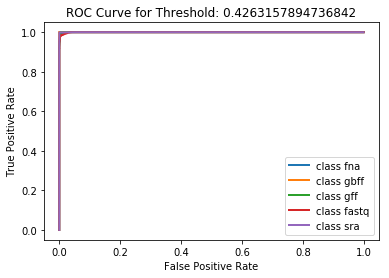

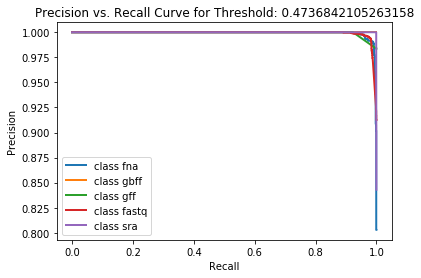

<Figure size 1440x720 with 0 Axes>

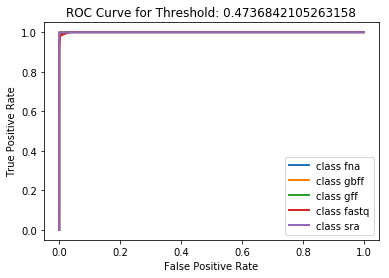

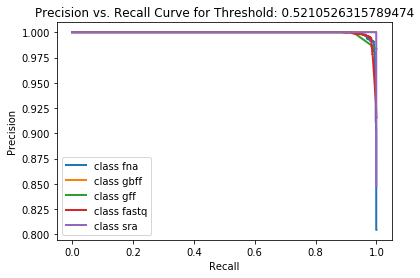

<Figure size 1440x720 with 0 Axes>

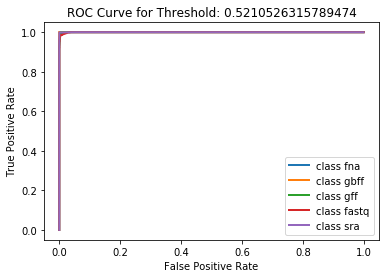

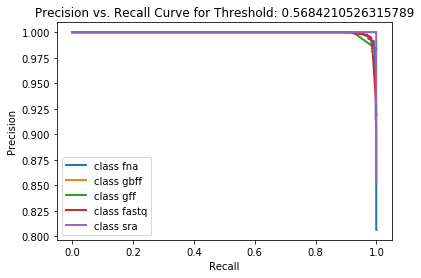

<Figure size 1440x720 with 0 Axes>

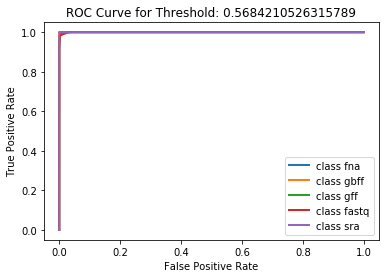

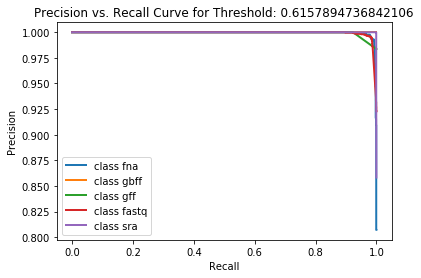

<Figure size 1440x720 with 0 Axes>

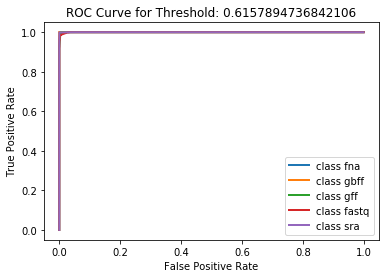

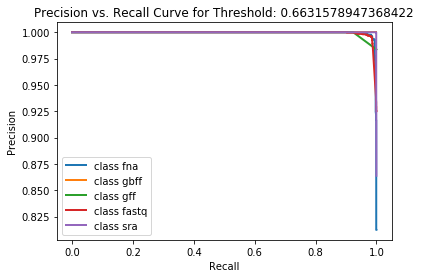

<Figure size 1440x720 with 0 Axes>

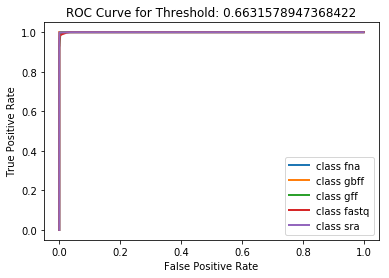

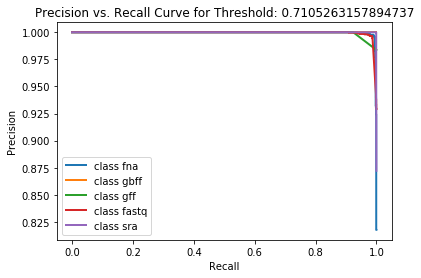

<Figure size 1440x720 with 0 Axes>

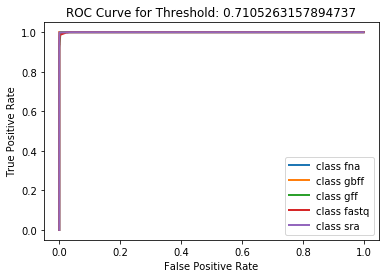

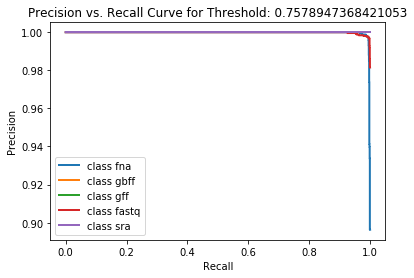

<Figure size 1440x720 with 0 Axes>

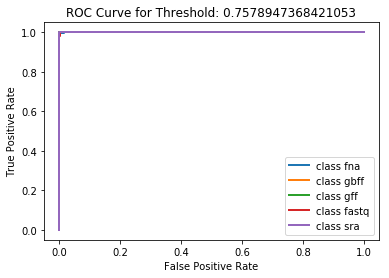

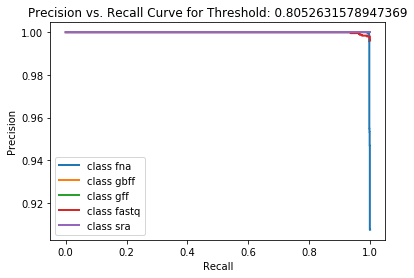

<Figure size 1440x720 with 0 Axes>

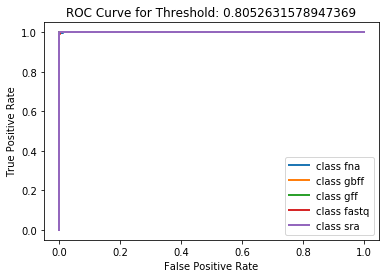

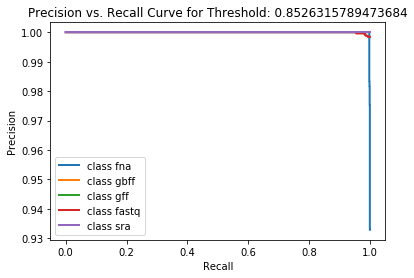

<Figure size 1440x720 with 0 Axes>

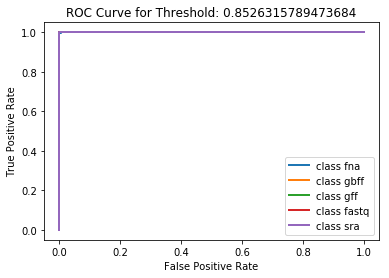

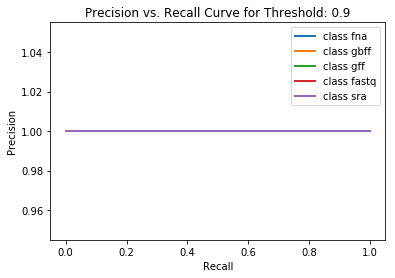

<Figure size 1440x720 with 0 Axes>

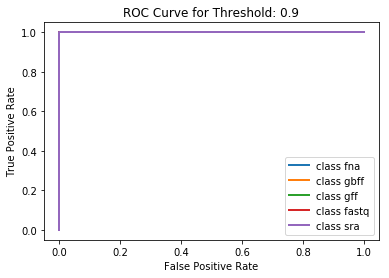

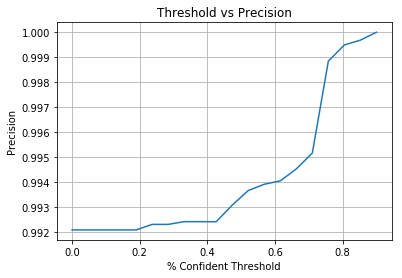

<Figure size 1440x720 with 0 Axes>

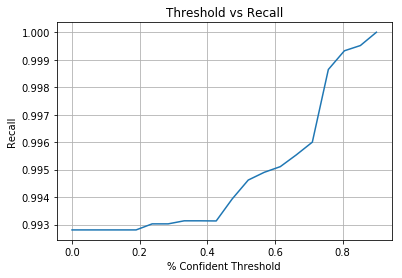

<Figure size 1440x720 with 0 Axes>

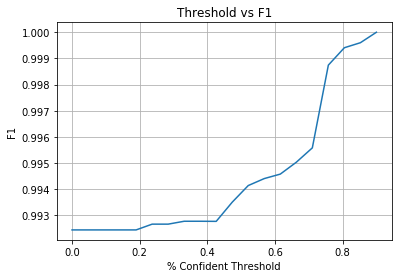

<Figure size 1440x720 with 0 Axes>

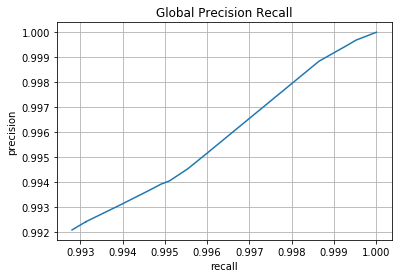

<Figure size 1440x720 with 0 Axes>

8959
9723
0.9214234289828243


array([2, 4, 0, ..., 0, 4, 3])

In [411]:
# Diagnostics on Validation Set
TestFileClassifier(model2, dat2_val, filetype, y_val, output = False, threshold = np.linspace(0, .9, 20), threshold_plots = True)

In [371]:
dat2_test = test_char_vectorizer(X_test)

Loading Character Vectorizer...
Character Vectorizer Loaded
['aaaa', 'tttt', 'tatt', 'taaa', 'gaaa', 'aaat', 'aatt', 'attt', 'ttta', 'agaa', 'aaga', 'gaag', 'tion', 'ion ', ' gen', 'geno', 'enom', 'nome', ' :: ', 'atio', 'tion ', 'genom', 'enome', 'ation', '=gen', 'prot', 'rote', 'otei', 'tein', 'prote', 'rotei', 'otein', 'protei', 'rotein', 'protein', 'gene', 'gggg', 'ffff', 'hhhh', 'fffff', 'ggggg', 'ffffff', 'gggggg', 'fffffff', 'ggggggg', 'gggggggg', 'ffffffff', 'iiii', '\x01\x00\x00\x00', '\x00\x00\x00\x00', '\x00\x00\x00$', '\x00\x00$\x01', '\x00$\x01\x00', '$\x01\x00\x00', '\x00\x00\x00\x00\x00', '\x00\x00\x00\x00$', '\x00\x00$\x01\x00', '\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00', '\x00\x00\x00\x00\x00\x00\x00\x00']
Vectorizer Load Time: 74


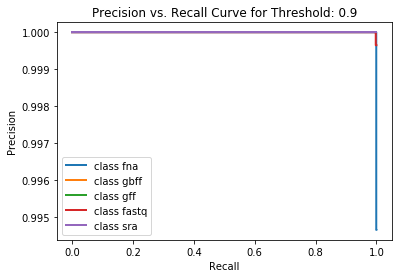

<Figure size 1440x720 with 0 Axes>

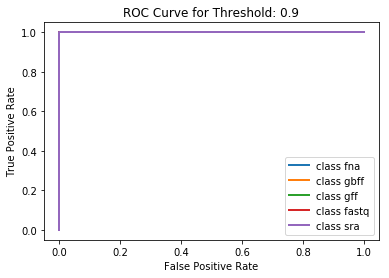

Precision: 0.9999298737727911
Recall: 0.9999022004889977
F1: 0.9999160369394257
Class fna mean and sd: [0.89027894, 0.060339328], Accuracy: 1.0
Class gbff mean and sd: [0.90340936, 0.02006291], Accuracy: 1.0
Class gff mean and sd: [0.8895342, 0.04708752], Accuracy: 1.0
Class fastq mean and sd: [0.89167744, 0.05178991], Accuracy: 1.0
Class sra mean and sd: [0.9059973, 0.00020664485], Accuracy: 1.0


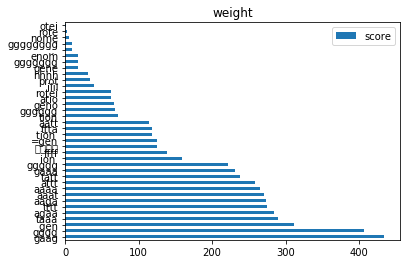

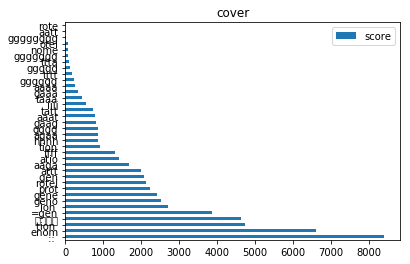

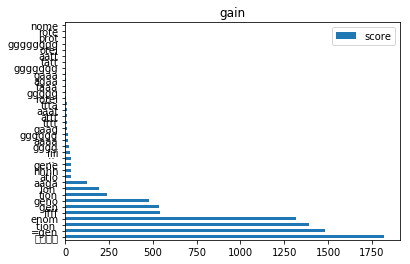

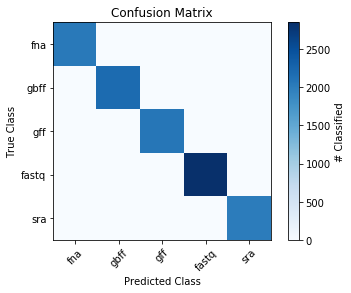

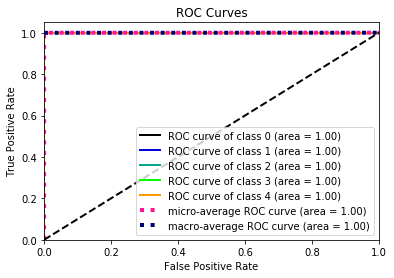

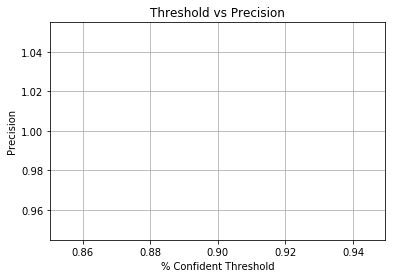

<Figure size 1440x720 with 0 Axes>

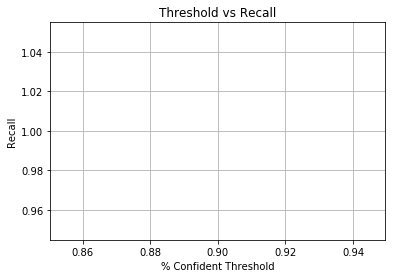

<Figure size 1440x720 with 0 Axes>

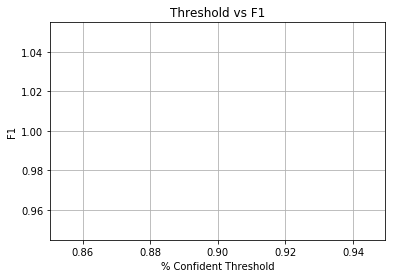

<Figure size 1440x720 with 0 Axes>

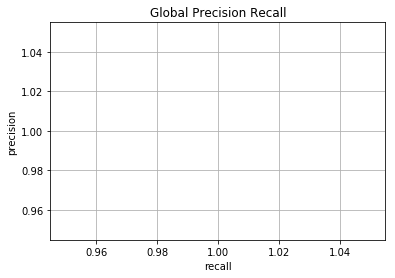

<Figure size 1440x720 with 0 Axes>

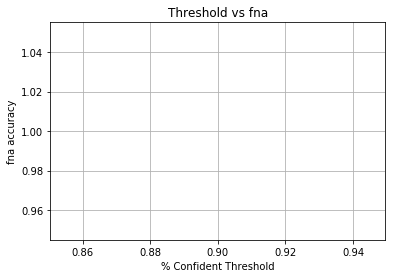

<Figure size 1440x720 with 0 Axes>

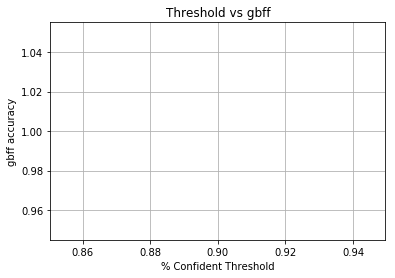

<Figure size 1440x720 with 0 Axes>

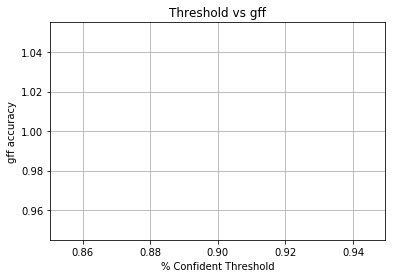

<Figure size 1440x720 with 0 Axes>

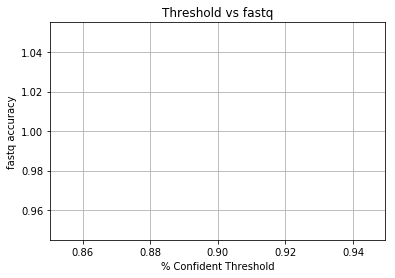

<Figure size 1440x720 with 0 Axes>

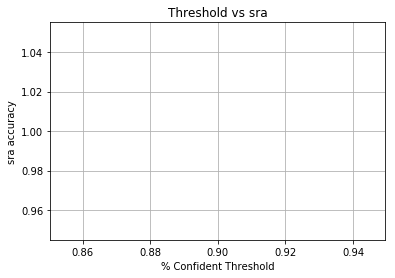

<Figure size 1440x720 with 0 Axes>

11180
12154
0.9198617739015962


array([3, 3, 1, ..., 1, 2, 3])

In [412]:
TestFileClassifier(model2, dat2_test,filetype, y_test, output = True, threshold = [.9], threshold_plots = True)

In [ ]:
# Results from trained vectorizer and model from 3000 Set
# 1000Char Test Set at 90% Threshold we keep 72.6%. 8826/12154
# 2000Char Test Set at 90% Threshold we keep 90.2%. 10965/12154
# 3000Char Test Set at 90% Threshold we keep 91.9% 11212/12154
# 4000Char Test Set at 90% Threshold we keep 91.4% 11108/12154
# ROC/AUC, Precision/Recall curve per class